This example demonstrates the use of `BayesianMarkovStateModel` and `ContinuousTimeMSM` for
estimating the uncertainty in the equilibrium probability distribution (e.g. free energy) and
relaxation timescales in a Markov state model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pp
from mdtraj.utils import timing
from msmbuilder.cluster import NDGrid
from msmbuilder.example_datasets import QuadWell
from msmbuilder.msm import BayesianMarkovStateModel
from msmbuilder.msm import ContinuousTimeMSM

For this example, we'll run some Brownian dynamics simulations of a 1D system with 4
metastable states. The potential energy function is

$$V = 4(x^8 + 0.8 \exp(-80 x^2) + 0.2 \exp(-80 (x-0.5)^2) + 0.5 \exp(-40 (x+0.5)^2)).$$

In [2]:
n_states = 25
lag_time = 10
quadwell = QuadWell(random_state=0)
seqs = NDGrid(n_states).fit_transform(quadwell.get()['trajectories'])
print(seqs[0])

loading "/home/gerry/msmbuilder_data/quadwell/version-1_random-state-0.pkl"...
[13 13 13 ..., 19 19 19]


We fit two models:
 - The first model is a `ContinuousTimeMSM`, which estimates the transition rates between the states using maximum likelihood and quantitifies its uncertainty using a Normal approximation.
 - The second model, `BayesianMarkovStateModel`, estimates an ensemble of discrete-time Markov models, using MCMC sampling of the transition matrix likelihood surface, using a sampler described in _P. Metzner, F. Noe and C. Schutte, Phys. Rev. E_ 80 021106 (2009).
 
For the error bars, the `BayesianMarkovStateModel` is something of a 'gold-standard', but it can be difficult utilize because it's pretty slow, and tuning the number of chains, number of samples, and number of steps between each sample is important to
get accurate results. The `ContinuousTimeMSM` on the other hand is not stochastic, and much faster.

In [3]:
with timing('ContinuousTimeMSM'):
    rates_model = ContinuousTimeMSM(lag_time=lag_time,).fit(seqs)
with timing('BayesianMarkovStateModel'):
    # generating 1000 samples from the distribution, using 2e4 steps between samples
    # to ensure that they're decorrelated
    bayes_model = BayesianMarkovStateModel(lag_time=lag_time, n_samples=int(1e3), n_steps=1e4).fit(seqs)

ContinuousTimeMSM: 3.106 seconds
BayesianMarkovStateModel: 3.910 seconds


In order to obtain reliable data from the samples produced by `BayesianMarkovStateModel`, we need to make sure
that the chain is well-mixed. Visually, we can start by looking at a trace of some property of the model (e.g.
the longest releaxation timescale) over the iterations of the sampler.

/usr/local/lib/python2.7/dist-packages/msmbuilder-3.3.0.dev0-py2.7-linux-x86_64.egg/msmbuilder/msm/bayesmsm.py:339: RuntimeWarning: invalid value encountered in log
  timescales = - self.lag_time / np.log(us[:, 1:])


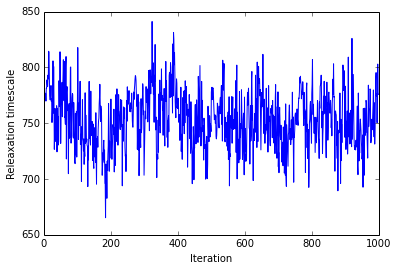

In [4]:
pp.plot(bayes_model.all_timescales_[:, 0])
pp.xlabel('Iteration')
pp.ylabel('Releaxation timescale')

You can see that the timeseries of the longest relaxation process is auto-correlated, which means that we need to take care
when drawing inferences from the mean and standard deviation of the samples, since it might not be fully equilibrated.


Now, lets plot a comparison of the two models. First, we look at the populations vector, the stationary distribution of
the models. This proportional to the log of the free energy of the states.

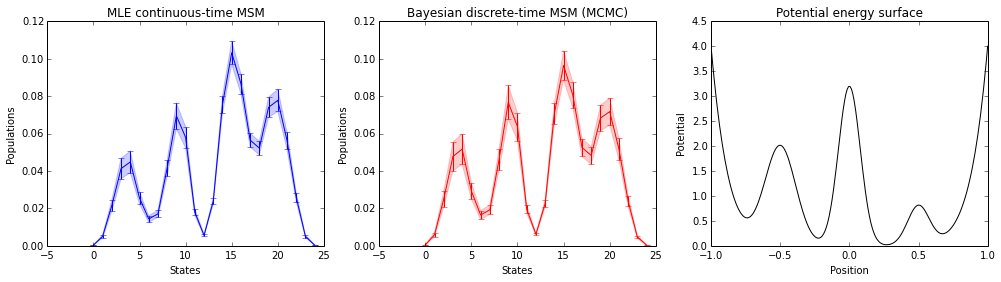

In [5]:
pp.figure(figsize=(14,4))
pp.grid(False)

# SUBPLOT 1. ContinuousTimeMSM
pp.subplot(1,3,1, axisbg='white')
# the mean and 2-std error bars in the populations
rates_mean = rates_model.populations_
rates_err = 2*rates_model.uncertainty_pi()
pp.errorbar(x=np.arange(n_states), y=rates_mean, yerr=rates_err, color='b')
pp.fill_between(x=np.arange(n_states), y1=rates_mean+rates_err, y2=rates_mean-rates_err, color='b', alpha=0.2)
pp.title('MLE continuous-time MSM')
pp.xlabel('States')
pp.ylabel('Populations')

# SUBPLOT 2. ContinuousTimeMSM
pp.subplot(1,3,2, axisbg='white')
# the mean and 2-std error bars in the populations, from
# averaging over the MCMC samples
bayes_mean = np.mean(bayes_model.all_populations_, axis=0)
bayes_err = 2*np.std(bayes_model.all_populations_, axis=0)
pp.errorbar(x=np.arange(n_states), y=bayes_mean, yerr=bayes_err, c='r')
pp.fill_between(x=np.arange(n_states), y1=bayes_mean+bayes_err, y2=bayes_mean-bayes_err, color='r', alpha=0.2)
pp.title('Bayesian discrete-time MSM (MCMC)')
pp.xlabel('States')
pp.ylabel('Populations')

# SUBPLOT3. Potential energy
pp.subplot(1,3,3, axisbg='white')
pp.title('Potential energy surface')
pp.xlabel('Position')
pp.ylabel('Potential')
# the potential function
potential_x = np.linspace(-1, 1, 200)
V = quadwell.potential(potential_x)
pp.plot(potential_x, V, 'k')

pp.tight_layout()

We can also look at the three longest relaxation timescales, and their uncertainty.

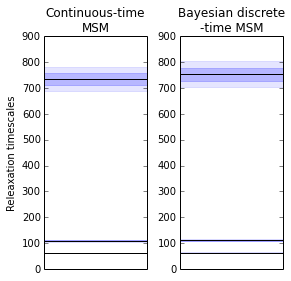

In [6]:
def plot_bars(timescales, sigma_ts):
    pp.xticks([])
    for t, s in zip(timescales, sigma_ts):
        pp.errorbar([0, 1], [t, t], c='k')
        pp.fill_between([0, 1], y1=[t-s, t-s], y2=[t+s, t+s], color='b', alpha=0.2)
        pp.fill_between([0, 1], y1=[t-2*s, t-2*s], y2=[t+2*s, t+2*s], color='b', alpha=0.1)


pp.subplot(1,3,1, axisbg='white')
pp.ylabel('Releaxation timescales')
pp.title('Continuous-time\nMSM')
pp.ylim(0, 900)
plot_bars(rates_model.timescales_[:3], rates_model.uncertainty_timescales()[:3])

pp.subplot(1,3,2, axisbg='white')
pp.title('Bayesian discrete\n-time MSM')
pp.ylim(0, 900)
plot_bars(np.mean(bayes_model.all_timescales_, axis=0)[:3], np.std(bayes_model.all_timescales_, axis=0)[:3])

pp.tight_layout()